# Credit Card Default Classification Project



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

%matplotlib inline

#pd.options.display.max_columns = None

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Data

In [3]:
df = pd.read_csv('DATA/training_data.csv',  index_col = 0)
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning & EDA

It seems like there's a row that's supposed to be the header.

In [4]:
df = df.rename(columns = df.loc['ID'])
df = df.drop([df.index[0], 'ID'])
df = df.rename(columns = {'default payment next month': 'Y'})

In [5]:
#df.info()

They are still all objects. Let's take a look at each of their unique values, if they don't have to be objects, I'll convert them.

In [6]:
#df.describe()

In [7]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y'],
      dtype='object')

In [8]:
categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
for c in df.columns:
    if c not in categorical: 
        df[c] = pd.to_numeric(df[c])

#for c in df.columns[0:5]:
#    print (f"{c}: {df[c].unique()}")

### Default (Y)

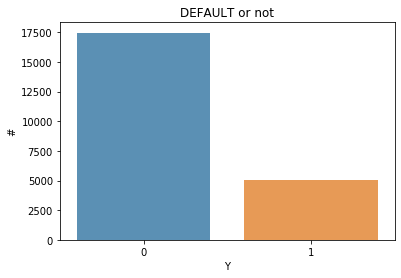

In [9]:
sns.countplot(df['Y'], alpha =.80)
plt.title('DEFAULT or not')
plt.ylabel('#')
plt.show()

### Credit Limit

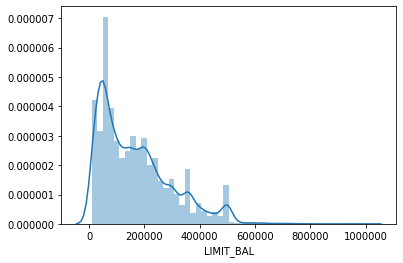

In [10]:
sns.distplot(df.LIMIT_BAL)

Some people seems to have very high credit limit, but nothing look abnormal.

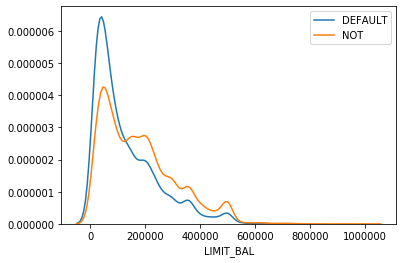

In [11]:
sns.distplot(df[df.Y == 1]['LIMIT_BAL'], hist = False, label='DEFAULT')
sns.distplot(df[df.Y == 0]['LIMIT_BAL'], hist = False, label='NOT')

plt.legend()
plt.show()

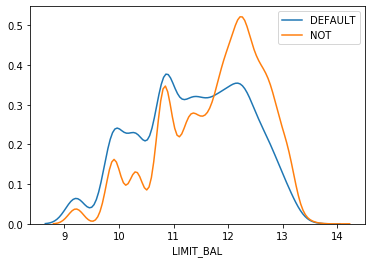

In [12]:
# try normalizing
sns.distplot(np.log(df[df.Y == 1]['LIMIT_BAL']), hist = False, label='DEFAULT')
sns.distplot(np.log(df[df.Y == 0]['LIMIT_BAL']), hist = False, label='NOT')

plt.legend()
plt.show()

### SEX

In [13]:
df.SEX.value_counts()

2    13571
1     8927
Name: SEX, dtype: int64

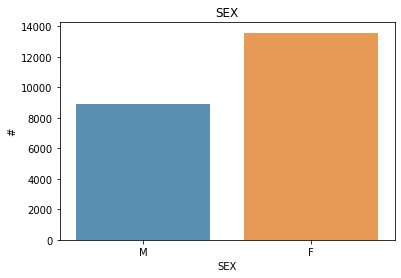

In [14]:
sns.countplot(df['SEX'], alpha =.80)
plt.title('SEX')
plt.xticks([0, 1], ['M', 'F'])
plt.ylabel('#')
plt.show()

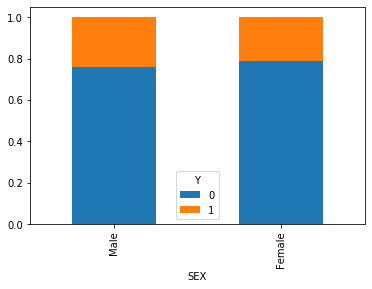

In [15]:
tmp = df.groupby(['SEX']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

Data is a little skewed towards females.

### Education

In [16]:
df.EDUCATION.value_counts()

2    10516
1     7918
3     3713
5      208
4       90
6       42
0       11
Name: EDUCATION, dtype: int64

There are unknown values above 4. We can roughly assume that higher education is linked to higher credit limit. Let's see if this matches up with the number system. 

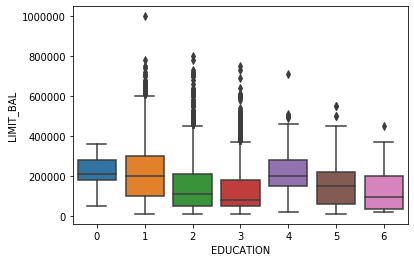

In [17]:
sns.boxplot(df.EDUCATION, df.LIMIT_BAL)

Okay, we cannot treat this as an ordinal group. We will treat as categorical.

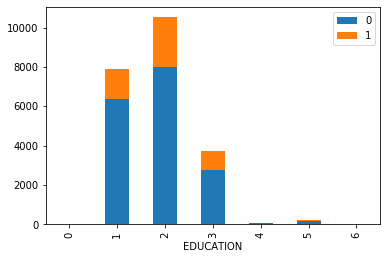

In [18]:
tmp = df.groupby(['EDUCATION']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

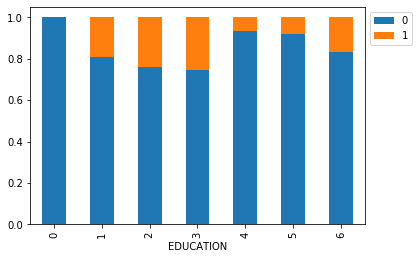

In [19]:
tmp = df.groupby(['EDUCATION']).Y.value_counts(normalize = True).unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.legend(bbox_to_anchor = [1, 1])
plt.show()

### MARRIAGE

In [20]:
df.MARRIAGE.value_counts()

2    12025
1    10195
3      234
0       44
Name: MARRIAGE, dtype: int64

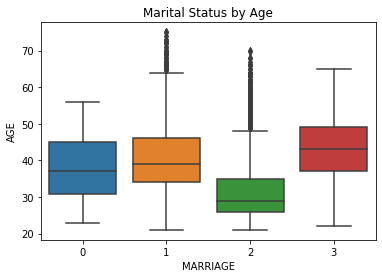

In [21]:
sns.boxplot(x = 'MARRIAGE', y = 'AGE', data = df).set_title('Marital Status by Age')
plt.show()

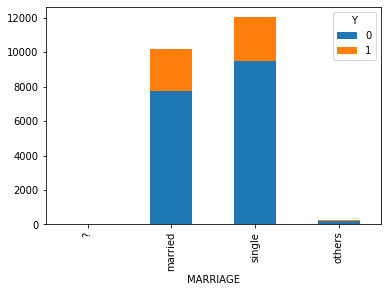

In [22]:
tmp = df.groupby(['MARRIAGE']).Y.value_counts().unstack()
tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1, 2, 3], ['?', 'married', 'single', 'others'])
plt.show()

I'm guessing 0 values are ones we don't have the information for but I'm going to just combine it with others, since they are very small numbers.

In [23]:
df.MARRIAGE = df.MARRIAGE.replace('3', '0')

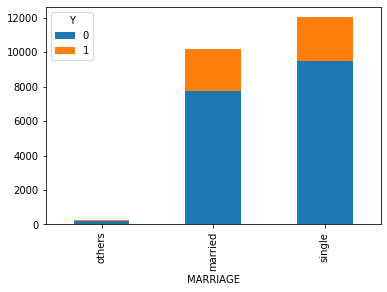

In [24]:
tmp = df.groupby(['MARRIAGE']).Y.value_counts().unstack()

tmp.plot(kind = 'bar', stacked = True)
plt.xticks([0, 1, 2], ['others', 'married', 'single'])
plt.show()


### Age

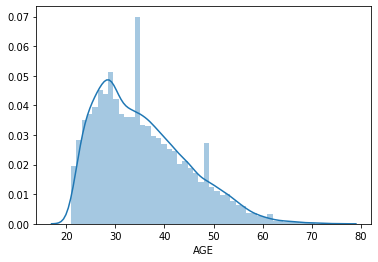

In [25]:
sns.distplot(df.AGE)

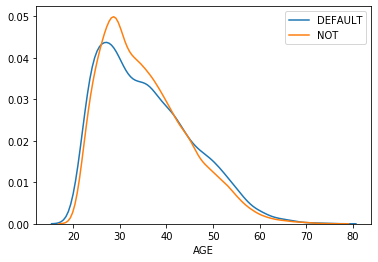

In [26]:
sns.distplot(df[df.Y == 1]['AGE'], hist = False, label='DEFAULT')
sns.distplot(df[df.Y == 0]['AGE'], hist = False, label='NOT')

plt.legend()
plt.show()

# Baseline Model
I'll create a basline logistic regression model using demographics only. 

In [27]:
def fit_logreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    logreg = LogisticRegression(class_weight = 'balanced')
    logreg.fit(X_train, y_train)    
    y_pred_test = logreg.predict(X_test)
    print(f"F1: {round(f1_score(y_test, y_pred_test), 3)}")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred_test), 3)}")
    print(f"Recall: {round(recall_score(y_test, y_pred_test), 3)}")
    return logreg

In [28]:
y = df['Y']
X = pd.get_dummies(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]) # removing one manually
X = X.drop(['SEX_2', 'EDUCATION_0', 'MARRIAGE_2'], axis = 1)

In [29]:
def corr_high(df):
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df['v1'] != corr_df['v2'])].sort_values(
        by = 'c', ascending = False)

corr_high(X)[1]

,v1,v2,c


In [30]:
lr = fit_logreg(X, y)

F1: 0.0
Accuracy: 0.771
Recall: 0.0


In [31]:
df = pd.get_dummies(df)
df = df.drop(['SEX_2', 'EDUCATION_0', 'MARRIAGE_2'], axis = 1)

### History of past payment
PAY0 ~ 6 are past payment status backwards (from Sept ~ April).  
Repayment status measurement scale is...  
-1: paid ontime  
1: delayed for one month  
2: delayed for 2 months  ...  
8: delayed for 8 months  
9: delayed for nine + months  

I want to first see if there are no values I don't understand.

In [32]:
pay_hist_names =[c for c in df if c.startswith('PAY')][0:6]

In [33]:
df[pay_hist_names].apply(lambda x: x.unique())

PAY_0    [-1, -2, 0, 2, 1, 3, 8, 4, 6, 5, 7]
PAY_2    [-1, -2, 0, 2, 3, 4, 7, 5, 1, 8, 6]
PAY_3    [-1, -2, 0, 2, 3, 4, 6, 5, 7, 8, 1]
PAY_4    [-1, -2, 0, 2, 4, 5, 3, 7, 6, 8, 1]
PAY_5       [-1, -2, 0, 2, 4, 3, 7, 5, 6, 8]
PAY_6       [-1, -2, 0, 2, 4, 3, 7, 6, 8, 5]
dtype: object

Okay, there are 0 and -2, which are not the values we are supposed to have. I'll try to sample someone and see if we can figure it out.

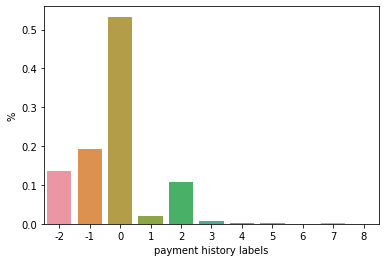

In [34]:
Y = pd.melt(df[pay_hist_names], value_vars = pay_hist_names).value.value_counts(normalize = True)
X = Y.index

sns.barplot(X, Y)
plt.xlabel('payment history labels')
plt.ylabel('%')
plt.show()

I want to assume that 0 is on time payment. But I'll feed in as categorical for now.  
On the other hand, these measures may highly correlating with others, since they can be accumulating balance.  
So we need a better measure for these that are not time sensative. We will add some measures later and remove these.  

In [35]:
#corr_high(df)[1]

### Amount of Billing Statement & Payment
BILL_AMT1 ~ 6 are also backward statement from September ~ April.  
PAY_AMT1~6 are previous payment from Sept ~ April.  

In [36]:
bill_amt_names = [c for c in df if c.startswith('BILL_AMT')]
pay_amt_names = [c for c in df if c.startswith('PAY_AMT')]

In [37]:
# making a dataframe so I can plot performance each month
tmp2 = pd.melt(df[bill_amt_names].reset_index(), id_vars = 'index', value_vars=bill_amt_names, value_name='bill_amount')
tmp2 = tmp2.replace(tmp2.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp3 = pd.melt(df[pay_amt_names].reset_index(), id_vars = 'index', value_vars=pay_amt_names, value_name='pay_amount')
tmp3 = tmp3.replace(tmp3.variable.unique(), [1, 2, 3, 4, 5, 6])

tmp = tmp2.merge(tmp3)

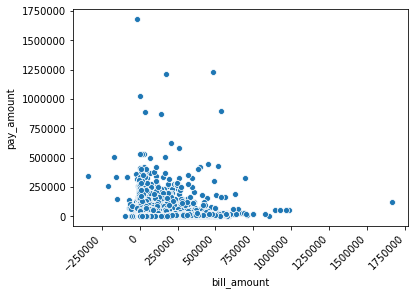

In [38]:
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp)
plt.xticks(rotation=45, ha='right')
plt.show()

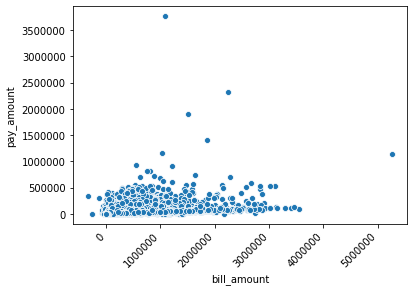

In [39]:
tmp_b = tmp.groupby('index').sum()
sns.scatterplot(x = 'bill_amount', y = 'pay_amount', data = tmp_b)
plt.xticks(rotation=45, ha='right')
plt.show()

In [40]:
#tmp[tmp['index'] == tmp_b[tmp_b['pay_amount'] > 3500000].index[0]]
#tmp[tmp['index'] == tmp_b[tmp_b['bill_amount'] > 5000000].index[0]]

Some outliers, but I have no evidence to delete them.

### Feature Engineering

#### Payment History
Instead of having each month record, I'll add the number of time for each category. 

In [41]:
payment_hist = pd.melt(df.reset_index(), id_vars = 'index', value_vars=pay_hist_names).groupby(['index', 'value']).count().unstack()
payment_hist = payment_hist.fillna(0)
payment_hist.columns = ['pay_hist_n2', 'pay_hist_n1', 'pay_hist_0', 'pay_hist_1', 'pay_hist_2', 'pay_hist_3', 'pay_hist_4', 
                       'pay_hist_5', 'pay_hist_6', 'pay_hist_7', 'pay_hist_8']

In [42]:
df = df.join(payment_hist)
cols_to_drop = pay_hist_names

#### Add the Balance Info (at the end of the month)
I'll remove this later.

In [43]:
for i in range(1, 7):
    df[f"BAL_{i}"] = df[f"BILL_AMT{i}"] - df[f"PAY_AMT{i}"]

In [44]:
cols_to_drop = cols_to_drop + bill_amt_names + [c for c in df if c.startswith("BAL_")]

#### Add the cumulative change of balance

In [45]:
for i in [6, 5, 4, 3, 2]:
    df[f"BAL_change_{i}"] = df[f"BAL_{i}"] - df[f"BAL_{i-1}"]

In [46]:
df["cum_bal_change"] = df[[c for c in df if c.startswith('BAL_change')]].sum(axis = 1)

In [47]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith("BAL_change")]

#### final balance and payment

In [48]:
df['final_balance'] = df['BAL_1']

In [49]:
df['final_payment'] = df['PAY_AMT1']

#### Add N_Default
How often they paid less than minimum.

In [50]:
for i in range(1, 7):
    df[f"DEF_{i}"] = np.where(((df[f"BILL_AMT{i}"] >= 35) & (df[f"PAY_AMT{i}"] < 35)) | 
                              ((df[f"BILL_AMT{i}"] < 35) & (df[f"PAY_AMT{i}"] < df[f"BILL_AMT{i}"])), 1, 0)

In [51]:
df['N_underpayment'] = df[[c for c in df if c.startswith('DEF')]].sum(axis = 1)

In [52]:
cols_to_drop = cols_to_drop + ['DEF_1']

#### Add Over Credit Limit
number of times they spent over the credit limit.

In [53]:
for i in range(1, 7):
    df[f"over_lim_{i}"] = np.where(df[f"BILL_AMT{i}"] > df[f"LIMIT_BAL"], 1, 0)

In [54]:
df["n_over_lim"] = df[[c for c in df if c.startswith('over_lim')]].sum(axis = 1)

In [55]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('over_lim')]

#### Add Percent Use
Percentage of credit limit used

In [56]:
for i in range(1, 7):
    df[f"percent_use_{i}"] = df[f"BILL_AMT{i}"] / df[f"LIMIT_BAL"]
    
df['avg_percent_use'] = df[[c for c in df if c.startswith('percent_use')]].mean(axis = 1)

In [57]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_use')]

#### Add Pattern Change
Add percent of payment to balance then subtract the most recent one from the old one

In [58]:
for i in range(1, 7):
    df[f"percent_paid_{i}"] = np.where(df[f"BILL_AMT{i}"] > 0, df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i}"], 1)
    
df['payment_patter_change'] = df['percent_paid_6'] - df['percent_paid_1']

In [59]:
cols_to_drop = cols_to_drop + [c for c in df if c.startswith('percent_paid')]

#### Add Average Percent Paid

In [60]:
df['payment_average_p'] = df[[c for c in df if c.startswith('percent_paid')]].mean(axis = 1)

#### Transform to a Log Limit
data was highly right skewed. it'll fit better if we normalize it a bit.

In [61]:
df['ln_limit_bal'] = np.log(df['LIMIT_BAL'])

In [62]:
cols_to_drop = cols_to_drop + ['LIMIT_BAL']

### Plot everything
Let's take a look at relationship between new variables and target. 

In [88]:
from sklearn.preprocessing import StandardScaler
y = df['Y'].values
X = df.drop(['Y'] + cols_to_drop, axis = 1)

scaler = StandardScaler()
scaler.fit(X)
X1 = pd.DataFrame(scaler.transform(X), columns= X.columns)
X1['Y'] = y

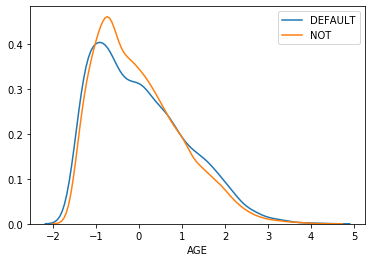

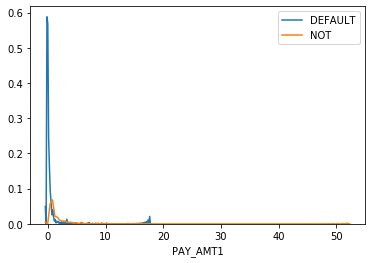

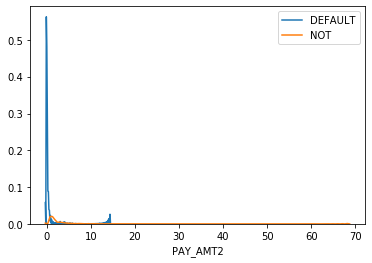

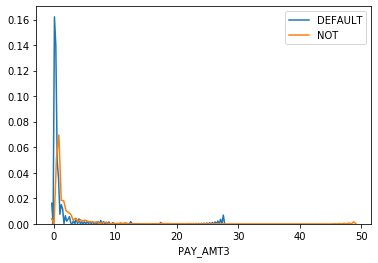

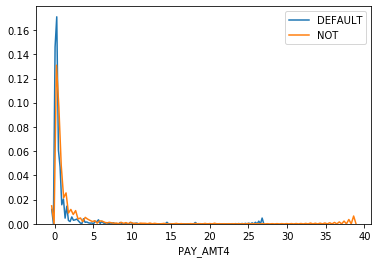

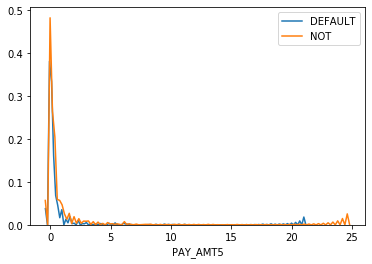

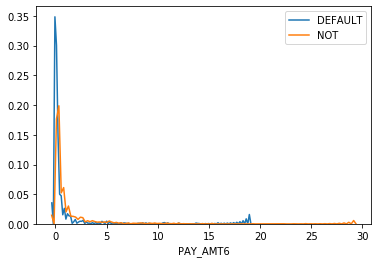

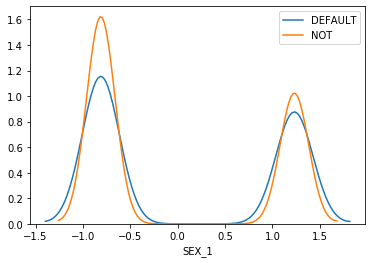

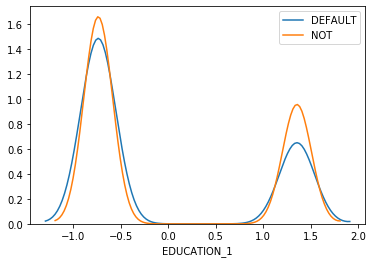

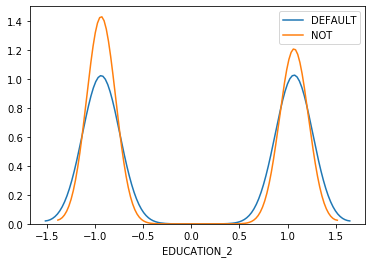

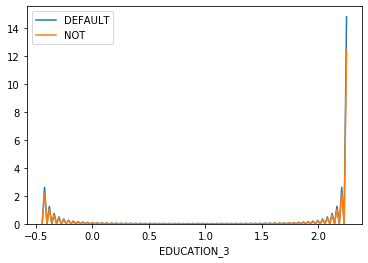

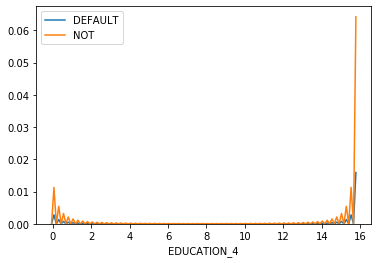

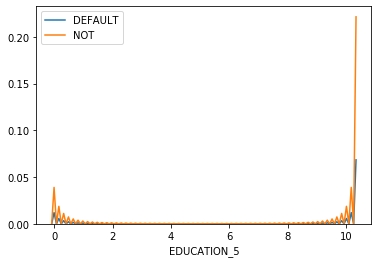

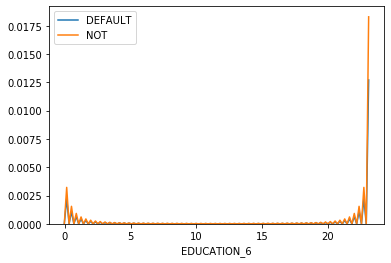

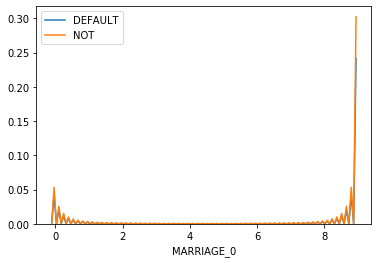

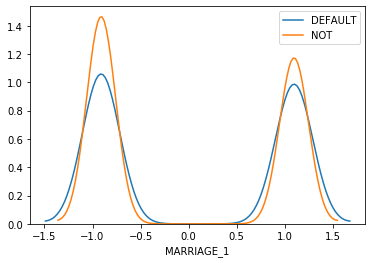

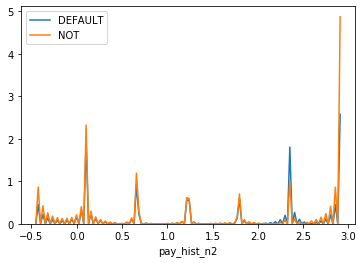

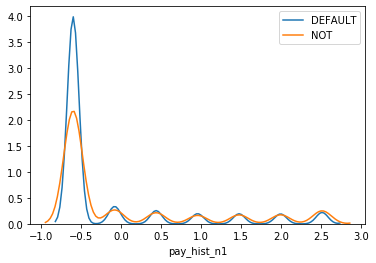

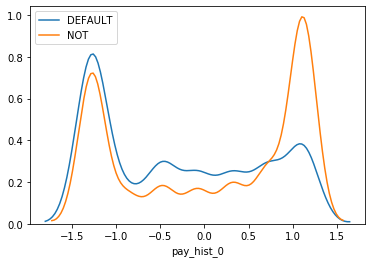

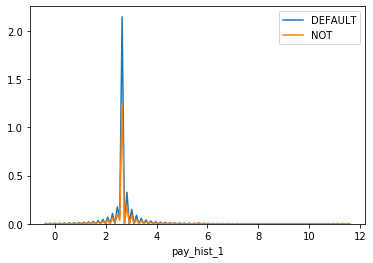

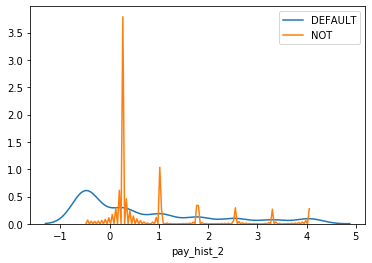

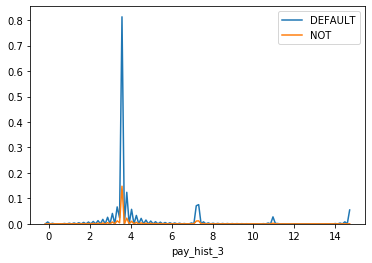

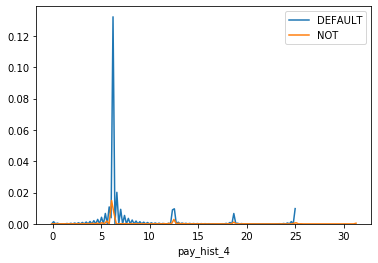

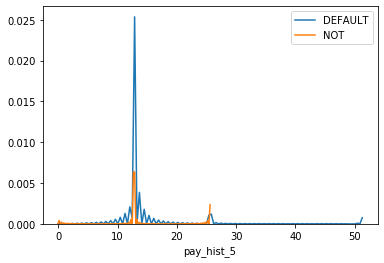

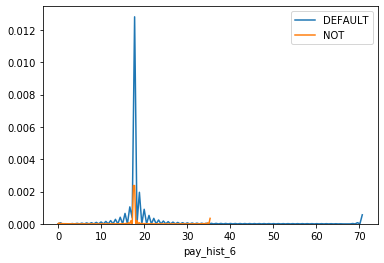

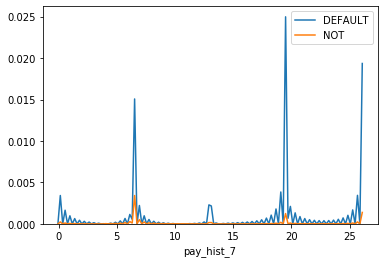

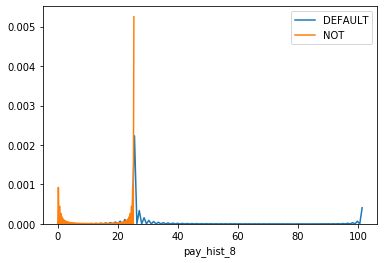

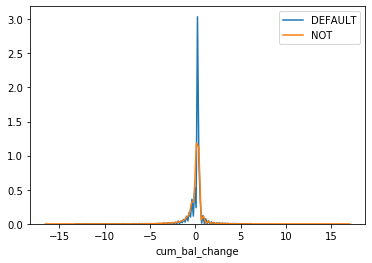

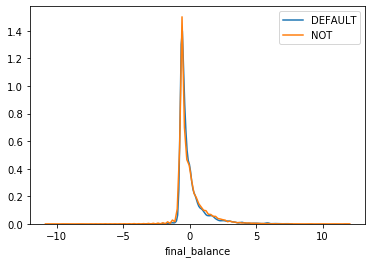

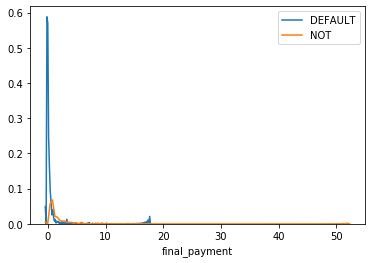

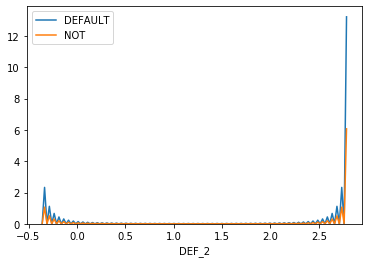

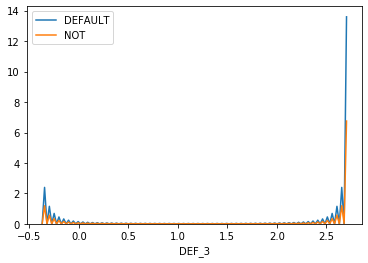

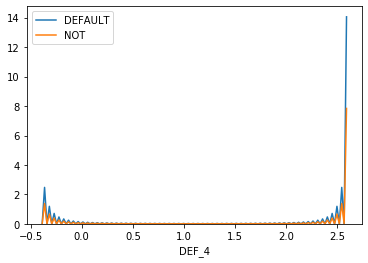

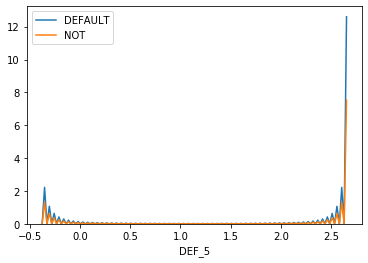

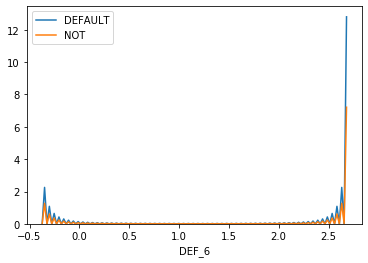

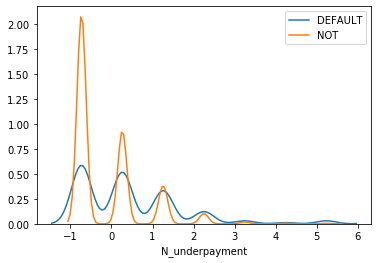

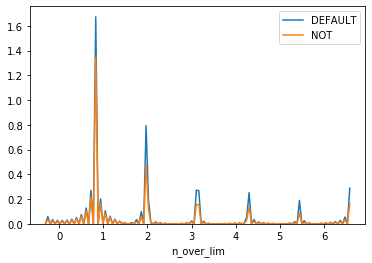

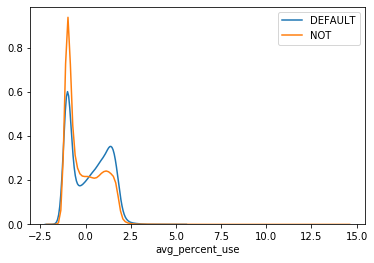

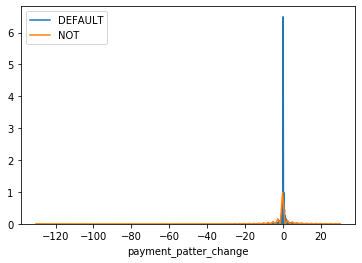

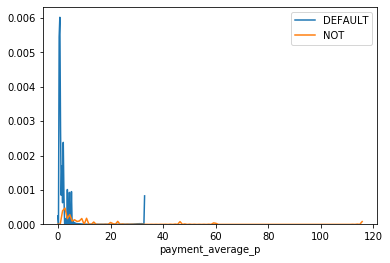

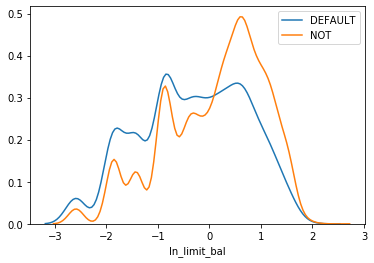

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


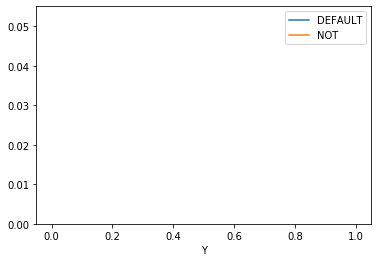

In [90]:
for c in X1.columns:
    
    sns.distplot(X1[X1.Y == 1][c], hist = False, label='DEFAULT')
    sns.distplot(X1[X1.Y == 0][c], hist = False, label='NOT')

    plt.legend()
    plt.show()

### Fit everything

In [99]:
y = df['Y']
X = df.drop(['Y'], axis = 1)
lr1 = fit_logreg(X, y)

F1: 0.376
Accuracy: 0.681
Recall: 0.42


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Fit all after manually dropping old features

In [137]:
y = df['Y']
X = df.drop(['Y'] + cols_to_drop, axis = 1)
lr2 = fit_logreg(X, y)

F1: 0.452
Accuracy: 0.581
Recall: 0.755


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Much better F1 and accuracy, but it's still useless.

## Model Evaluation / Regularization
### 1. VIF

In [72]:
X = df.drop(['Y'] + cols_to_drop, axis = 1)

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [75]:
X = df.drop(['Y'] + list(Vif.Features[Vif.VIF > 10].values), axis = 1)
lr3 = fit_logreg(X, y)

F1: 0.348
Accuracy: 0.691
Recall: 0.36


### 2. Ridge

In [86]:
X = df.drop(['Y'], axis = 1)

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression

def fit_ridge(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    scale = StandardScaler()
    X_train_transformed = scale.fit_transform(X_train)
    X_test_transformed = scale.transform(X_test)
    
    ridge = Ridge(alpha=0.5)
    ridge.fit(X_train_transformed, y_train)
    
    return ridge



In [98]:
fit_ridge(X, y)
y_pred_test = ridge.predict(X_test_transformed)

ValueError: Expected 2D array, got 1D array instead:
array=[1 0 1 ... 0 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.